<a href="https://colab.research.google.com/github/ostramarkus/nobelanalys/blob/master/Nobel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analys av Nobelprisen

## Introduktion och frågeställningar
> Nobelpriset är årliga internationella utmärkelser, som av tre svenska och en norsk institution tilldelas personer som "gjort mänskligheten den största nytta" inom fysik, kemi, fysiologi eller medicin, litteratur och fredsarbete. Priserna fastställdes av dynamitens uppfinnare, Alfred Nobel, genom hans testamente från 1895, och delades ut första gången 1901. Varje nobelpris anses som den mest prestigefyllda utmärkelsen inom sitt område. – <cite>[Wikipedia][1]</cite>

[1]:http://www.quotedb.com/quotes/2112

I den här dataanalysen undersöker vi utdelningen av Nobelpriset. Syftet är att hitta eventuella mönster och trender. Vi vill t.ex. undersöka:
* Hur ser könsfördelningen ut - och hur har den förändrats över tid?
* Från vilka länder kommer pristagarna? Är något land överrepresenterat?
* Pristagarnas ålder - har snittåldern förändrats över tid?


## Förberedelser

### Importera kodbibliotek och bestämma stilmall för diagram

Först importerar vi de kodbibliotek vi behöver för analysen.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

Sedan bestämmer vi stilen på våra diagram.

In [0]:
plt.style.use('ggplot')

### Inläsning av data

Vår data kommer i form av en csv-fil (comma-separated values). Vi läser in filen i Pandas med metoden `read_csv`. Det vi får tillbaka är en så kallad `DataFrame` - ett objekt från Pandas-biblioteket för att lagra och hantera tabell-data. 

In [0]:
path = 'https://data.ostrawebb.se/nobel/nobel_data.csv'

In [0]:
df = pd.read_csv(path, sep=';')

Med metoden `head`kan vi lista de första raderna i tabellen.

In [10]:
df.head()

,Year,Category,Full name,Birth date,Birth city,Birth country,Sex,Organization name,Organization city,Organization country,Death date,Death city,Death country
0,1901,Chemistry,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany
1,1901,Literature,Sully Prudhomme,1839-03-16,Paris,France,Male,NaN,NaN,NaN,1907-09-07,Châtenay,France
2,1901,Medicine,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Male,Marburg University,Marburg,Germany,1917-03-31,Marburg,Germany
3,1901,Peace,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Male,NaN,NaN,NaN,1910-10-30,Heiden,Switzerland
4,1901,Peace,Frédéric Passy,1822-05-20,Paris,France,Male,NaN,NaN,NaN,1912-06-12,Paris,France


### Konvertera datatyper

För att underlätta jämförelser är det bra om de olika kolumnerna är i korrekta datatyper. Vi listar kolumnernas datatyper genom att skriva ut attributet `dtypes`.

In [11]:
df.dtypes

Year                     int64
Category                object
Full name               object
Birth date              object
Birth city              object
Birth country           object
Sex                     object
Organization name       object
Organization city       object
Organization country    object
Death date              object
Death city              object
Death country           object
dtype: object

In [13]:
# Konvertera kolumner med datum till datatypen datetime64
df['Birth Date'] = pd.to_datetime(df['Birth date'], format='%Y-%m-%d', errors="coerce") 
df['Death Date'] = pd.to_datetime(df['Death date'], format='%Y-%m-%d', errors="coerce")

date_nat = df[pd.isnull(df[['Birth Date', 'Death Date']]).any(axis=1)][['Birth Date', 'Death Date']].shape[0]

print("Antal rader med saknat eller ogitligt datum är:", date_nat, 'av', df.shape[0])


Antal rader med saknat eller ogitligt datum är: 353 av 969


Vi listar några av de rader som har ogiltiga datum:

In [14]:
df[pd.isnull(df[['Birth Date', 'Death Date']]).any(axis=1)].sample(4)

,Year,Category,Full name,Birth date,Birth city,Birth country,Sex,Organization name,Organization city,Organization country,Death date,Death city,Death country,Birth Date,Death Date
847,2008,Medicine,Luc Montagnier,1932-08-18,Chabris,France,Male,World Foundation for AIDS Research and Prevention,Paris,France,NaN,NaN,NaN,1932-08-18,NaT
824,2007,Chemistry,Gerhard Ertl,1936-10-10,Bad Cannstatt,Germany,Male,Fritz-Haber-Institut der Max-Planck-Gesellschaft,Berlin,Germany,NaN,NaN,NaN,1936-10-10,NaT
342,1960,Peace,Albert John Lutuli,1898-00-00,Bulawayo,Southern Rhodesia (Zimbabwe),Male,NaN,NaN,NaN,1967-07-21,Stanger,South Africa,NaT,1967-07-21
897,2011,Physics,Adam G. Riess,1969-12-16,"Washington, DC",United States of America,Male,Johns Hopkins University,"Baltimore, MD",United States of America,NaN,NaN,NaN,1969-12-16,NaT


Det verkar som om ogiltiga datum verkar handla om att pristagaren fortfarande lever eller att det är organisationer som fått pristet.

För säkerhets skull kan vi se om någon pristagare har ett dödsdatum men saknar födelsedatum.

In [15]:
df[(df['Birth Date'].isnull()) & (df['Birth Date'].notnull())].shape[0]

0

In [16]:
df.dtypes

Year                             int64
Category                        object
Full name                       object
Birth date                      object
Birth city                      object
Birth country                   object
Sex                             object
Organization name               object
Organization city               object
Organization country            object
Death date                      object
Death city                      object
Death country                   object
Birth Date              datetime64[ns]
Death Date              datetime64[ns]
dtype: object

## Undersökning av datan

Nu har vi läst in och konverterat vår data och är redo att börja utforska den. Vi kan börja med att undersöka hur många rader (alltså unika Nobelpris) datan består av. 

In [18]:
print('Tabellen har {} rader'.format(df.shape[0]))

Tabellen har 969 rader


### Könsfördelning
Vi börjar med att undersöka könsfördelningen på pristagarna. Vi skapar två serier hur många praistagare av varje kön det var för varje år.

In [0]:
females_series = df[df['Sex'] == 'Female'].groupby(['Year']).count()['Category']
males_series = df[df['Sex'] == 'Male'].groupby(['Year']).count()['Category']

Utifrån de serierna skapar vi en ny tabell: `gender_ratio`, med två kolumner - en för varje kön.

In [36]:
gender_ratio = pd.DataFrame({'Males': males_series, 'Females': females_series}).fillna(0)
gender_ratio.head()

,Males,Females
Year,,
1901,6,0.0
1902,7,0.0
1903,6,1.0
1904,5,0.0
1905,4,1.0


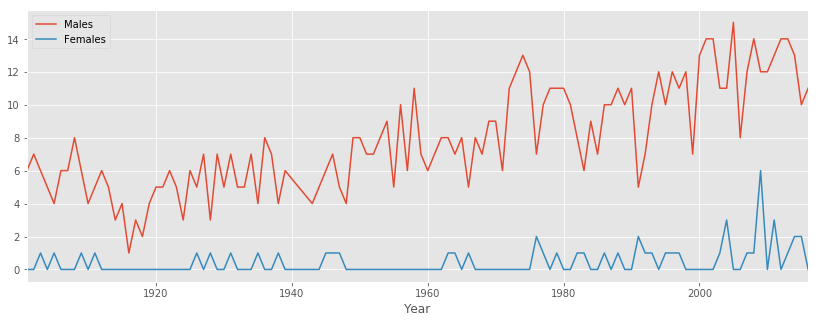

In [50]:
gender_ratio.plot(figsize=(14, 5))
plt.show()

Här ser vi hur snefördelad könsfördelningen varit under hela nittiotalet, med långa perioder utan någon kvinnlig pristagare. 

Vi ser dock att vi har ett år med ovanligt många kvinnliga pristagare, någon gång runt 2010. Vi tittar närmare på det året.

In [72]:
year_series = gender_ratio.sort_values(by="Females", ascending=False).iloc[0]
print("År {} fick {} kvinnor Nobelpriset.".format(year_series.name, year_series['Females']))

År 2009 fick 6.0 kvinnor Nobelpriset.


In [75]:
 df[df['Year'] == year_series.name]

,Year,Category,Full name,Birth date,Birth city,Birth country,Sex,Organization name,Organization city,Organization country,Death date,Death city,Death country,Birth Date,Death Date
853,2009,Chemistry,Venkatraman Ramakrishnan,NaN,"Chidambaram, Tamil Nadu",India,Male,MRC Laboratory of Molecular Biology,Cambridge,United Kingdom,NaN,NaN,NaN,NaT,NaT
854,2009,Chemistry,Thomas A. Steitz,1940-08-23,"Milwaukee, WI",United States of America,Male,Yale University,"New Haven, CT",United States of America,NaN,NaN,NaN,1940-08-23,NaT
855,2009,Chemistry,Thomas A. Steitz,1940-08-23,"Milwaukee, WI",United States of America,Male,Howard Hughes Medical Institute,NaN,NaN,NaN,NaN,NaN,1940-08-23,NaT
856,2009,Chemistry,Ada E. Yonath,1939-06-22,Jerusalem,British Mandate of Palestine (Israel),Female,Weizmann Institute of Science,Rehovot,Israel,NaN,NaN,NaN,1939-06-22,NaT
857,2009,Economics,Elinor Ostrom,1933-08-07,"Los Angeles, CA",United States of America,Female,Indiana University,"Bloomington, IN",United States of America,2012-06-12,"Bloomington, IN",United States of America,1933-08-07,2012-06-12
858,2009,Economics,Elinor Ostrom,1933-08-07,"Los Angeles, CA",United States of America,Female,Arizona State University,"Tempe, AZ",United States of America,2012-06-12,"Bloomington, IN",United States of America,1933-08-07,2012-06-12
859,2009,Economics,Oliver E. Williamson,1932-09-27,"Superior, WI",United States of America,Male,University of California,"Berkeley, CA",United States of America,NaN,NaN,NaN,1932-09-27,NaT
860,2009,Literature,Herta Müller,1953-08-17,"Nitzkydorf, Banat",Romania,Female,NaN,NaN,NaN,NaN,NaN,NaN,1953-08-17,NaT
861,2009,Medicine,Elizabeth H. Blackburn,1948-11-26,"Hobart, Tasmania",Australia,Female,University of California,"San Francisco, CA",United States of America,NaN,NaN,NaN,1948-11-26,NaT
862,2009,Medicine,Carol W. Greider,1961-04-15,"San Diego, CA",United States of America,Female,Johns Hopkins University School of Medicine,"Baltimore, MD",United States of America,NaN,NaN,NaN,1961-04-15,NaT
